In [0]:
import os
import numpy as np
import zipfile
from urllib import request
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import cv2
import glob 
import pandas as pd 
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

In [56]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
TRAIN_IMAGES = glob.glob('/content/drive/My Drive/dataset/train/train_data/*.jpg')
TEST_IMAGES = glob.glob('/content/drive/My Drive/dataset/test/test_data/*.jpg')

In [0]:
def load_image(path):
    image_list = np.zeros((len(path), 260, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(260, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

In [0]:
x_train = load_image(TRAIN_IMAGES)
x_test = load_image(TEST_IMAGES)

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

# The encoding process
input_img = Input(shape=(260, 540, 1))  

############
# Encoding #
############

# Conv1 #
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

# Conv2 #
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

# Conv 3 #
x = Conv2D(filters = 8, kernel_size=(3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

# Note:
# padding is a hyper-arameter for either 'valid' or 'same'. 
# "valid" means "no padding". 
# "same" results in padding the input such that the output has the same length as the original input.

In [0]:
############
# Decoding #
############

# DeConv1
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

# DeConv2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Deconv3
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
# Declare the model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [63]:
# Train the model
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test)
               )

Train on 55 samples, validate on 17 samples
Epoch 1/50
55/55 [==============================] - 13s 241ms/step - loss: 0.6676 - val_loss: 0.6465
Epoch 2/50
55/55 [==============================] - 13s 232ms/step - loss: 0.6469 - val_loss: 0.6169
Epoch 3/50
55/55 [==============================] - 13s 240ms/step - loss: 0.6174 - val_loss: 0.5700
Epoch 4/50
55/55 [==============================] - 13s 232ms/step - loss: 0.5705 - val_loss: 0.4989
Epoch 5/50
55/55 [==============================] - 13s 238ms/step - loss: 0.4989 - val_loss: 0.4100
Epoch 6/50
55/55 [==============================] - 13s 232ms/step - loss: 0.4076 - val_loss: 0.3432
Epoch 7/50
55/55 [==============================] - 14s 247ms/step - loss: 0.3349 - val_loss: 0.3343
Epoch 8/50
55/55 [==============================] - 13s 238ms/step - loss: 0.3202 - val_loss: 0.3328
Epoch 9/50
55/55 [==============================] - 13s 240ms/step - loss: 0.3192 - val_loss: 0.3320
Epoch 10/50
55/55 [============================

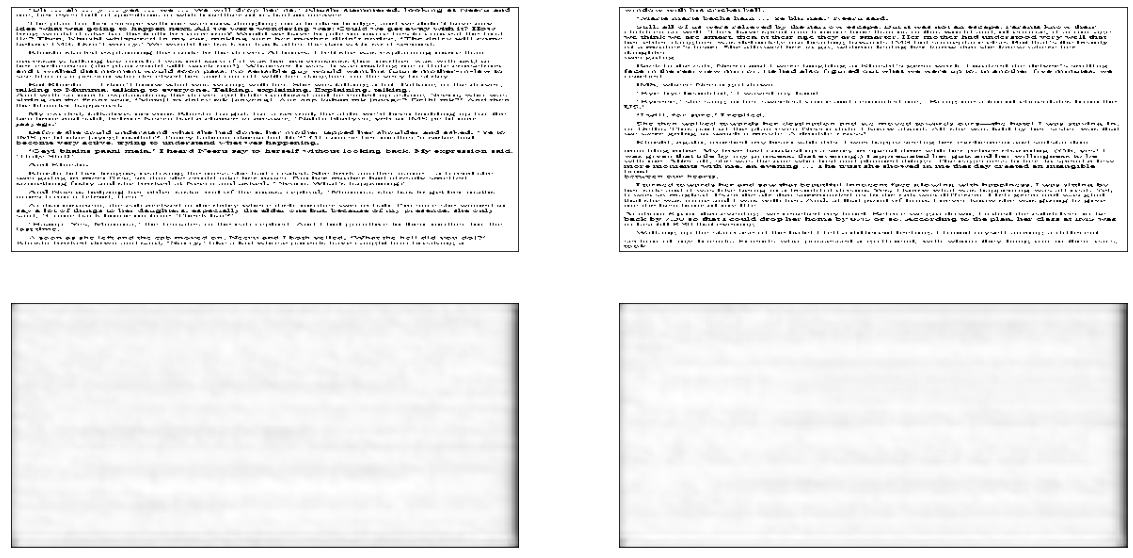

In [64]:
decoded_imgs = autoencoder.predict(x_test)

n = 2

plt.figure(figsize=(20,10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(260, 540))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(260, 540))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

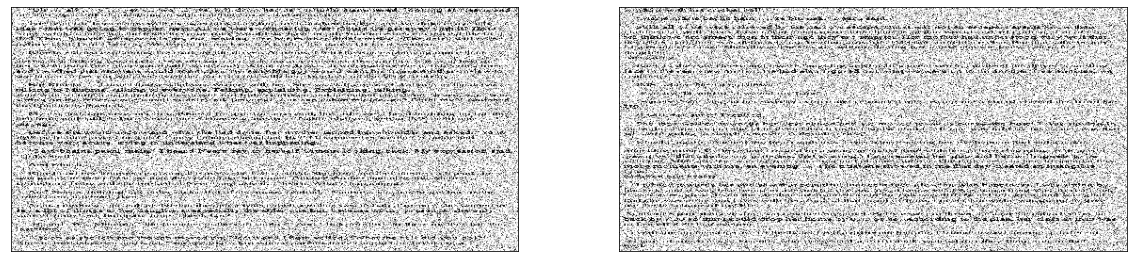

In [66]:
n = 2
plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(260, 540))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [67]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test)
               )

Train on 55 samples, validate on 17 samples
Epoch 1/50
55/55 [==============================] - 14s 258ms/step - loss: 0.3026 - val_loss: 0.3171
Epoch 2/50
55/55 [==============================] - 14s 256ms/step - loss: 0.3066 - val_loss: 0.3318
Epoch 3/50
55/55 [==============================] - 14s 257ms/step - loss: 0.3159 - val_loss: 0.3196
Epoch 4/50
55/55 [==============================] - 14s 256ms/step - loss: 0.3094 - val_loss: 0.3249
Epoch 5/50
55/55 [==============================] - 14s 259ms/step - loss: 0.3100 - val_loss: 0.3146
Epoch 6/50
55/55 [==============================] - 14s 263ms/step - loss: 0.3037 - val_loss: 0.3143
Epoch 7/50
55/55 [==============================] - 14s 259ms/step - loss: 0.3012 - val_loss: 0.3117
Epoch 8/50
55/55 [==============================] - 14s 256ms/step - loss: 0.3000 - val_loss: 0.3121
Epoch 9/50
55/55 [==============================] - 15s 267ms/step - loss: 0.2992 - val_loss: 0.3110
Epoch 10/50
55/55 [============================

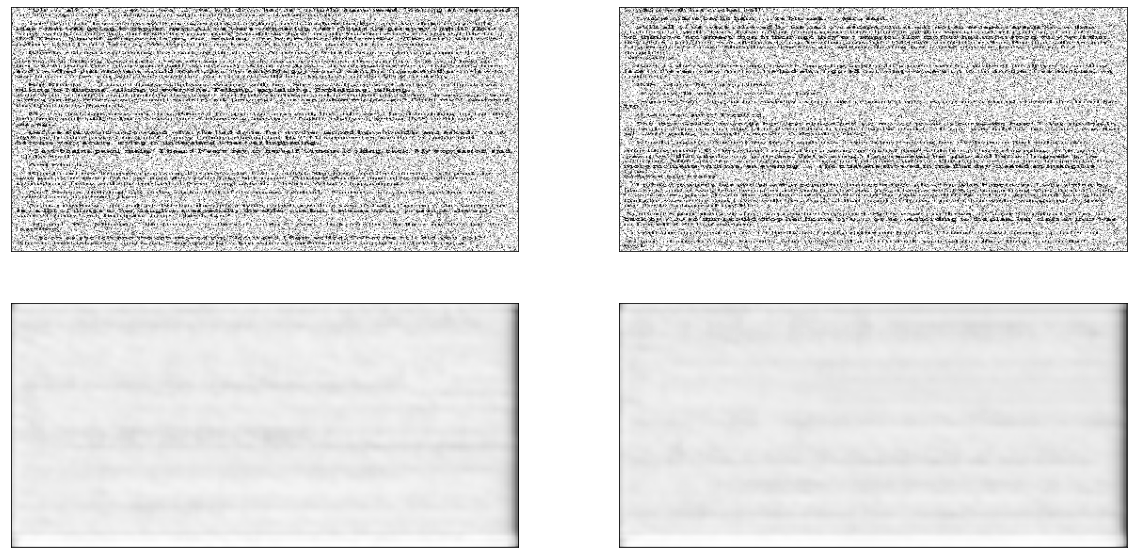

In [68]:
decoded_imgs = autoencoder.predict(x_test)

n = 2

plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(260, 540))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(260, 540))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()